In [ ]:
'''
measuring the effect of a particular drug combination on colon cancer.
Specifically, we'll be looking the effect of Levamisole and Fluorouracil on patients who have had surgery to remove their colon cancer. 
After surgery, the curability of the patient depends on the remaining residual cancer. 
In this study, it was found that this particular drug combination had a clear beneficial effect, when compared with Chemotherapy. 

In [ ]:
'''
    sex (binary): 1 if Male, 0 otherwise
    age (int): age of patient at start of the study
    obstruct (binary): obstruction of colon by tumor
    perfor (binary): perforation of colon
    adhere (binary): adherence to nearby organs
    nodes (int): number of lymphnodes with detectable cancer
    node4 (binary): more than 4 positive lymph nodes
    outcome (binary): 1 if died within 5 years
    TRTMT (binary): treated with levamisole + fluoroucil
    differ (one-hot): differentiation of tumor
    extent (one-hot): extent of local spread


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import random

In [ ]:
data = pd.read_csv("levamisole_data.csv",index_col=0)
print(f"shape of the data: {data.shape}")
data.head()

shape of the data: (607, 14)


,sex,age,obstruct,perfor,adhere,nodes,node4,outcome,TRTMT,differ_2.0,differ_3.0,extent_2,extent_3,extent_4
1,1,43,0,0,0,5.0,1,1,True,1,0,0,1,0
2,1,63,0,0,0,1.0,0,0,True,1,0,0,1,0
3,0,71,0,0,1,7.0,1,1,False,1,0,1,0,0
4,0,66,1,0,0,6.0,1,1,True,1,0,0,1,0
5,1,69,0,0,0,22.0,1,1,False,1,0,0,1,0


In [ ]:
def proportion_treated(df):
  proportion = np.sum(df['TRTMT']) / len(df)
  return proportion

In [ ]:
example_df = pd.DataFrame(data =[[0, 0],
                                 [1, 1], 
                                 [1, 1],
                                 [1, 1]], columns = ['outcome', 'TRTMT'])
print(example_df)
print("\n")
treated_proportion = proportion_treated(example_df)
print(f"Proportion of patient treated: computed {treated_proportion}")

   outcome  TRTMT
0        0      0
1        1      1
2        1      1
3        1      1


Proportion of patient treated: computed 0.75


In [ ]:
p = proportion_treated(data)
print(f"proportion treated: {p} ~ {int(p*100)}%")

proportion treated: 0.49093904448105435 ~ 49%


In [ ]:
def event_rate(df):
  treated_prob = 0.0
  control_prob = 0.0
  treated_prob = len(df[(df['TRTMT']==True) & (df['outcome']==1)]) / len(df[df['TRTMT']==True]) 
  control_prob = len(df[(df['TRTMT']==False) & (df['outcome']==1)]) / len(df[df['TRTMT']==True])
  return treated_prob,control_prob 

In [ ]:
example_df = pd.DataFrame(data =[[0, 1],
                                 [1, 1], 
                                 [1, 1],
                                 [0, 1],
                                 [1, 0],
                                 [1, 0],
                                 [1, 0],
                                 [0, 0]], columns = ['outcome', 'TRTMT'])
print(example_df)
print("\n")
treated_prob, control_prob = event_rate(example_df)
print(f"Treated 5-year death rate: {treated_prob:.4f}")
print(f"Control 5-year death rate: {control_prob:.4f}")

   outcome  TRTMT
0        0      1
1        1      1
2        1      1
3        0      1
4        1      0
5        1      0
6        1      0
7        0      0


Treated 5-year death rate: 0.5000
Control 5-year death rate: 0.7500


In [ ]:
treated_prob, control_prob = event_rate(data)
print(f"Death rate for treated patients: {treated_prob:.4f} ~ {int(treated_prob*100)}%")
print(f"Death rate for untreated patients: {control_prob:.4f} ~ {int(control_prob*100)}%")

Death rate for treated patients: 0.3725 ~ 37%
Death rate for untreated patients: 0.5000 ~ 50%


In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(18)
data = data.dropna(axis=0)
y = data.outcome
x = data.drop('outcome',axis=1)
x_dev,x_test,y_dev,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [ ]:
print(f"dev set shape: {x_dev.shape}")
print(f"test set shape: {x_test.shape}")

dev set shape: (455, 13)
test set shape: (152, 13)


In [ ]:
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression(penalty='l2',solver="lbfgs",max_iter=10000).fit(x_dev,y_dev)

In [ ]:
def extract_treatment_effect(lr,data):
  theta_TRTMT = 0.0
  TRTMT_OR = 0.0
  coeffs = {data.columns[i]:lr.coef_[0][i] for i in range(len(data.columns))}
  theta_TRTMT = coeffs["TRTMT"]
  TRTMT_OR = np.exp(theta_TRTMT)
  return theta_TRTMT,TRTMT_OR

In [ ]:
theta_TRTMT, trtmt_OR = extract_treatment_effect(lr, x_dev)
print(f"Theta_TRTMT: {theta_TRTMT:.4f}")
print(f"Treatment Odds Ratio: {trtmt_OR:.4f}")

Theta_TRTMT: -0.2885
Treatment Odds Ratio: 0.7494


In [ ]:
def OR_to_ARR(p,OR):
  odds_baseline = p/(1-p)
  odds_trtmt = OR * odds_baseline
  p_trtmt = odds_trtmt/(1+odds_trtmt)
  ARR = p - p_trtmt
  return ARR 

In [ ]:
test_p, test_OR = (0.75, 0.5)
print(f"baseline p: {test_p}, OR: {test_OR}")
print(f"Output: {OR_to_ARR(test_p, test_OR):.4f}")

baseline p: 0.75, OR: 0.5
Output: 0.1500


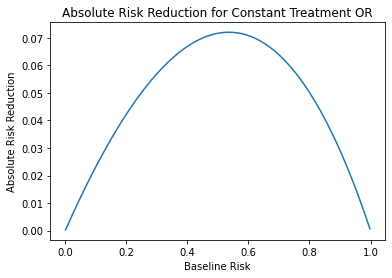

In [ ]:
ps = np.arange(0.001, 0.999, 0.001)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs)
plt.title("Absolute Risk Reduction for Constant Treatment OR")
plt.xlabel('Baseline Risk')
plt.ylabel('Absolute Risk Reduction')
plt.show()

In [ ]:
'''
The baseline risk is the model's predicted probability that the patient is predicted to die if they do not receive treatment.
we are gonna later use the baseline risk of each patient to organize patients into risk groups (that have similar baseline risks).

In [ ]:
def base_risk(x,lr_model):
  x = x.copy(deep=True)
  x["TRTMT"] = 0 
  risks = lr_model.predict_proba(x)[:,1]
  return risks


In [ ]:
def lr_ARR_quantile(x,y,lr):
  x = x.copy(deep=True)
  df = x.copy(deep=True)
  baseline_risk = base_risk(df,lr)
  risk_groups = pd.cut(baseline_risk,10)
  df.loc[:,'baseline_risk'] = baseline_risk
  df.loc[:,'risk_groups'] = risk_groups
  df.loc[:,'y'] = y
  df_baseline = df[df["TRTMT"]==False]
  df_treatment = df[df["TRTMT"]==True]
  baseline_mean_by_risk_group = df_baseline.groupby('risk_groups')['y'].mean()
  treatment_mean_by_risk_group = df_treatment.groupby('risk_groups')['y'].mean()
  arr_by_risk_group = baseline_mean_by_risk_group - treatment_mean_by_risk_group
  arr_by_risk_group.index = df.groupby('risk_groups')['baseline_risk'].mean()
  arr_by_risk_group.name = 'ARR'
  return arr_by_risk_group 

In [ ]:
abs_risks = lr_ARR_quantile(x_dev,y_dev,lr)
print(abs_risks)
display(pd.DataFrame(abs_risks))

baseline_risk
0.231595    0.089744
0.314713    0.042857
0.386342   -0.014604
0.458883    0.122222
0.530568    0.142857
0.626937   -0.104072
0.693404    0.150000
0.777353    0.293706
0.836617    0.083333
0.918884    0.200000
Name: ARR, dtype: float64


,ARR
baseline_risk,
0.231595,0.089744
0.314713,0.042857
0.386342,-0.014604
0.458883,0.122222
0.530568,0.142857
0.626937,-0.104072
0.693404,0.150000
0.777353,0.293706
0.836617,0.083333


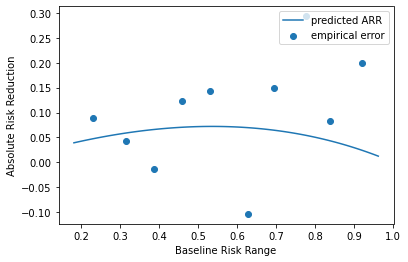

In [ ]:
plt.scatter(abs_risks.index,abs_risks,label="empirical error")
plt.ylabel("Absolute Risk Reduction")
plt.xlabel("Baseline Risk Range")
ps = np.arange(abs_risks.index[0]-0.05,abs_risks.index[-1]+0.05,0.01)
diffs = [OR_to_ARR(p,trtmt_OR) for p in ps]
plt.plot(ps,diffs,label="predicted ARR")
plt.legend(loc="upper right")
plt.show()

In [ ]:
'''
The C-for-benefit

P(P1 has a predicted ARR greater than P2|P1 experiences greater risk reduction than P2),

    Pair 1 consists of two patients (A,B), where A receives treatment, B does not.
    Pair 2 is another pair of two patients (A,B), where A receives treatment, B does not.

The risk reduction for each pair is:

    1 if the treated person A survives and the untreated B person does not (treatment helps).
    -1 if the treated person A dies and the untreated person B doesn't (treatment harms)
    0 otherwise (treatment has no effect, because both patients in the pair live, or both die).


In [ ]:
'''
obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }

Here is the interpretation of this dictionary for a pair of patients, (A,B), where A receives treatment and B does not:

    When patient A does not die, and neither does patient B, (0, 0), the observed benefit of treatment is 0.
    When patient A does not die, but patient B does die, (0, 1), the observed benefit is -1 (the treatment helped).
    When patient A dies, but patient B does not die, (1, 0), the observed benefit is 1 (the treatment was harmful)
    When patient A dies and patient B dies, (0, 0), the observed benefit of treatment is 0.

Each patient in the pair is represented by a tuple (ARR, y).

In [ ]:
def c_for_benefit_score(pairs):
  obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }
  obs_benefit = [obs_benefit_dict[(i[1],j[1])] for (i,j) in pairs]
  pred_benefit = [np.mean([i[0],j[0]]) for (i,j) in pairs]
  concordant_count,permissible_count,risk_tie_count = 0,0,0
  for i in range(len(pairs)):
    for j in range(i+1,len(pairs)):
      if obs_benefit[i] != obs_benefit[j]:
        permissible_count += 1
        if ((obs_benefit[i]<obs_benefit[j]) == (pred_benefit[i]<pred_benefit[j])):
          concordant_count += 1 
          if (pred_benefit[i] == pred_benefit[j]):
            risk_tie_count +=1
  cstat = (concordant_count + (0.5 * risk_tie_count)) / permissible_count
  return cstat 

In [ ]:
def c_statistics(pred_rr,y,w,random_seed=0):
  assert len(pred_rr) == len(w) == len(y)
  tuples = tuple(zip(pred_rr,y,w))
  untreated = list(filter(lambda x : x[2] == 0,tuples))
  treated = list(filter(lambda x: x[1] == 1,tuples))
  if len(treated) < len(untreated):
    untreated = random.sample(untreated,len(treated))
  if len(untreated) < len(treated):
    treated = random.sample(treated,len(untreated))
  assert len(untreated)  == len(treated)
  untreated = sorted(untreated,key=lambda x : x[0])
  treated = sorted(treated,key=lambda x:x[0])
  pairs = tuple(zip(treated,untreated))
  cstat = c_for_benefit_score(pairs)
  return cstat

In [ ]:
tmp_pred_rr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tmp_y = [0,1,0,1,0,1,0,1,0]
tmp_w = [0,0,0,0,1,1,1,1,1]
tmp_cstat = c_statistics(tmp_pred_rr, tmp_y, tmp_w)
print(f"C-for-benefit calculated is {tmp_cstat}")

C-for-benefit calculated is 0.25


In [ ]:
def treatment_control(x):
  x_treatment = x.copy(deep=True)
  x_control = x.copy(deep=True)
  x_treatment.loc[:,'TRTMT'] = 1
  x_control.loc[:,'TRTMT'] = 0
  return x_treatment,x_control 
def risk_reduction(model,data_treatment,data_control):
  treatment_risk = model.predict_proba(data_treatment)[:,1]
  control_risk = model.predict_proba(data_control)[:,1]
  return control_risk - treatment_risk

In [ ]:
x_test_treated,x_test_untreated = treatment_control(x_test)
rr_lr = risk_reduction(lr,x_test_treated,x_test_untreated)

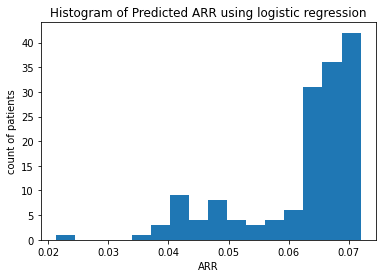

In [ ]:
plt.hist(rr_lr, bins='auto')
plt.title("Histogram of Predicted ARR using logistic regression")
plt.ylabel("count of patients")
plt.xlabel("ARR")
plt.show()

In [ ]:
tmp_cstat_test = c_statistics(rr_lr, y_test, x_test.TRTMT)
print(f"Logistic Regression evaluated by C-for-Benefit: {tmp_cstat_test:.4f}")

Logistic Regression evaluated by C-for-Benefit: 0.4636


In [ ]:
!pip install lifelines

In [ ]:
from lifelines.utils import concordance_index
tmp_regular_cindex = concordance_index(y_test, lr.predict_proba(x_test)[:, 1])
print(f"Logistic Regression evaluated by regular C-index: {tmp_regular_cindex:.4f}")

Logistic Regression evaluated by regular C-index: 0.7785


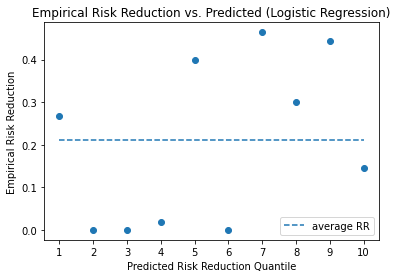

In [ ]:
def quantile_benefit(x, y, arr_hat):
    df = x.copy(deep=True)
    df.loc[:, 'y'] = y
    df.loc[:, 'benefit'] = arr_hat
    benefit_groups = pd.qcut(arr_hat, 10)
    df.loc[:, 'benefit_groups'] = benefit_groups
    empirical_benefit = df.loc[df.TRTMT == 0, :].groupby('benefit_groups').y.mean() - df.loc[df.TRTMT == 1].groupby('benefit_groups').y.mean()
    avg_benefit = df.loc[df.TRTMT == 0, :].y.mean() - df.loc[df.TRTMT==1, :].y.mean()
    return empirical_benefit, avg_benefit

def plot_empirical_risk_reduction(emp_benefit, av_benefit, model):
    plt.scatter(range(len(emp_benefit)), emp_benefit)
    plt.xticks(range(len(emp_benefit)), range(1, len(emp_benefit) + 1))
    plt.title("Empirical Risk Reduction vs. Predicted ({})".format(model))
    plt.ylabel("Empirical Risk Reduction")
    plt.xlabel("Predicted Risk Reduction Quantile")
    plt.plot(range(10), [av_benefit]*10, linestyle='--', label='average RR')
    plt.legend(loc='lower right')
    plt.show()

emp_benefit, avg_benefit = quantile_benefit(x_test, y_test, rr_lr)
plot_empirical_risk_reduction(emp_benefit, avg_benefit, "Logistic Regression")

In [ ]:
class TLearner():
  def __init__(self,treatment_estimator,control_estimator):
    self.treatment_estimator = treatment_estimator 
    self.control_estimator = control_estimator 
  def predict(self,x):
    risk_control = self.control_estimator.predict_proba(x)[:,1]
    risk_treatment = self.treatment_estimator.predict_proba(x)[:,1]
    pred_risk_reduction = risk_control - risk_treatment 
    return pred_risk_reduction 

In [ ]:
def holdout_grid_search(clf,x_train_hp,y_train_hp,x_val_hp,y_val_hp,hyperparam,verbose=False):
  best_estimator = None 
  best_hyperparam = {}
  best_score = 0.0
  hyper_param_l = list(hyperparam.values())
  combination_l_of_t = list(itertools.product(*hyper_param_l))
  combination_l_of_d = []
  for val_tuple in combination_l_of_t:
    param_d = {}
    for i,k in enumerate(hyperparam.keys()):
      param_d[k] = val_tuple[i]
    combination_l_of_d.append(param_d)
  for param_id in combination_l_of_d:
    estimator = clf(**param_d)
    estimator.fit(x_train_hp,y_train_hp)
    preds = estimator.predict_proba(x_val_hp)[:,1]
    estimator_score = concordance_index(y_val_hp,preds)
    if estimator_score > best_score:
      best_score = estimator_score 
      best_estimator = estimator
      best_hyperparam = param_d
  if verbose:
    print("hyperparam:")
    display(hyperparam)
    print("hyper_param_l")
    display(hyper_param_l)
    print("combination_l_of_t")
    display(combination_l_of_t)
    print(f"combination_l_of_d")
    display(combination_l_of_d)
    print(f"best_hyperparam")
    display(best_hyperparam)
    print(f"best_score: {best_score:.4f}")
  return best_estimator, best_hyperparam

In [ ]:
def treatment_dataset_split(x_train,y_train,x_val,y_val):
  x_treat_train = x_train[x_train['TRTMT']==1]
  x_treat_train = x_treat_train.drop("TRTMT",axis=1)
  y_treat_train = y_train[x_train['TRTMT']==1]
  x_treat_val = x_val[x_val["TRTMT"]==1]
  x_treat_val = x_treat_val.drop("TRTMT",axis=1)
  y_treat_val = y_val[x_val["TRTMT"]==1]
  x_control_train = x_train[x_train["TRTMT"]==0]
  x_control_train = x_control_train.drop('TRTMT',axis=1)
  y_control_train = y_train[x_train["TRTMT"]==0]
  x_control_val = x_val[x_val["TRTMT"]==0]
  x_control_val = x_control_val.drop('TRTMT',axis=1)
  y_control_val = y_val[x_val["TRTMT"]==0]
  return (x_treat_train, y_treat_train,
            x_treat_val, y_treat_val,
            x_control_train, y_control_train,
            x_control_val, y_control_val)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
x_train, x_val, y_train, y_val = train_test_split(x_dev, 
                                                  y_dev, 
                                                  test_size = 0.25,
                                                  random_state = 0)

In [ ]:
(x_treat_train, y_treat_train, 
 x_treat_val, y_treat_val,
 x_control_train, y_control_train,
 x_control_val, y_control_val) = treatment_dataset_split(x_train, y_train,
                                                         x_val, y_val)

In [ ]:
hyperparams = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 10, 40, None],
    'min_samples_leaf': [1, 0.1, 0.2],
    'random_state': [0]
}

In [ ]:
treatment_model, best_hyperparam_treat  = holdout_grid_search(RandomForestClassifier,
                                      x_treat_train, y_treat_train,
                                      x_treat_val, y_treat_val, hyperparams)

In [ ]:
control_model, best_hyperparam_ctrl = holdout_grid_search(RandomForestClassifier,
                                    x_control_train, y_control_train,
                                    x_control_val, y_control_val, hyperparams)

In [ ]:
t_learner = TLearner(treatment_model, control_model)

In [ ]:
rr_t_val = t_learner.predict(x_val.drop(['TRTMT'], axis=1))
print(f"X_val num of patients {x_val.shape[0]}")
print(f"rr_t_val num of patient predictions {rr_t_val.shape[0]}")

X_val num of patients 114
rr_t_val num of patient predictions 114


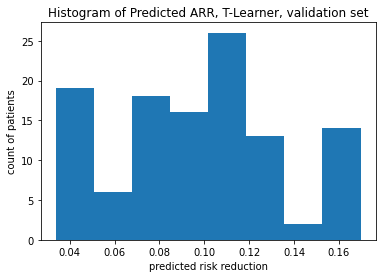

In [ ]:
plt.hist(rr_t_val, bins='auto')
plt.title("Histogram of Predicted ARR, T-Learner, validation set")
plt.xlabel('predicted risk reduction')
plt.ylabel('count of patients')
plt.show()

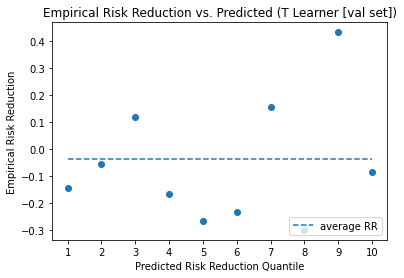

In [ ]:
empirical_benefit, avg_benefit = quantile_benefit(x_val, y_val, rr_t_val)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner [val set]')

In [ ]:
c_for_benefit_tlearner_val_set = c_statistics(rr_t_val, y_val, x_val.TRTMT)
print(f"C-for-benefit statistic of T-learner on val set: {c_for_benefit_tlearner_val_set:.4f}")

C-for-benefit statistic of T-learner on val set: 0.2637


In [ ]:
rr_t_test = t_learner.predict(x_test.drop(['TRTMT'], axis=1))

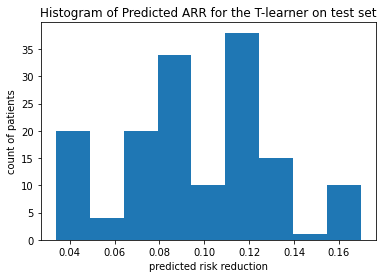

In [ ]:
plt.hist(rr_t_test, bins='auto')
plt.title("Histogram of Predicted ARR for the T-learner on test set")
plt.xlabel("predicted risk reduction")
plt.ylabel("count of patients")
plt.show()

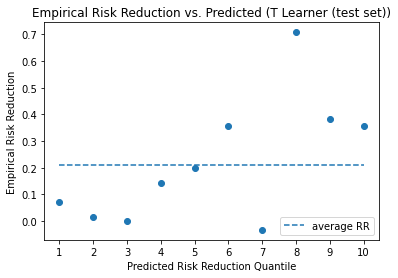

In [ ]:
empirical_benefit, avg_benefit = quantile_benefit(x_test, y_test, rr_t_test)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner (test set)')

In [ ]:
c_for_benefit_tlearner_test_set = c_statistics(rr_t_test, y_test, x_test.TRTMT)
print(f"C-for-benefit statistic of T-learner on test set: {c_for_benefit_tlearner_test_set:.4f}")

C-for-benefit statistic of T-learner on test set: 0.3348
